# MIC Workshop 3: Convolutional Neural Networks


## Background
Hope you're enjoying the first Deep Learning workshop so far! For these workshops, we'll typically use Google Colab, an online coding environment. This is so that we don't have to worry about installing all of the libraries on everyone's different computers. 

_____
You're now working in a Notebook. Notebooks have **cells**, each of which can be run by hitting Shift+Enter. Try it on the cell below!

_You will see the output of the particular cell right below it_

In [1]:
print("Notebooks are so much fun!!1!")

Notebooks are so much fun!!1!


In general, notebooks are a very suitable tool for machine learning/data science. We would also recommend trying [Jupyter Notebook](https://jupyter.org/install) if you haven't already

_For later workshops, we might opt out for a more involved environment like Docker in case we want to do anything fancier_
____
## Installing PyTorch
Don't worry too much about the contents of this cell. It basically just installs the right packages for you to run PyTorch code

If this cell is causing problems for you (like `tcmalloc`,  make sure you click "connect to Hosted runtime" from the dropdown menu in the top right)

In [0]:
# Installing pytorch, don't worry about the code in this cell. 
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = 'cpu' #cuda_output[0] if exists('/dev/nvidia0')

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

## Imports
PyTorch is really convenient because it has a lot of useful classes for us. Here are some examples:
* `torch.nn`: A neural network class
* `torch.utils.data`: Torch comes with preinstalled datasets so we don't need to handle them ourselves
* `torchvision`: A class holding useful image based models


In [0]:
import os
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt

# The Data
For this lab, we will revisit of the most (if not the most) popular datasets for machine learning - [MNIST](http://yann.lecun.com/exdb/mnist/). It is very accessible and is (was) used commonly used as a benchmark in academic literature. In this lab, we will use torchvision to import the dataset instead of the main pytorch library. 

You don't need to worry about the format too much now. But in general, getting the data in the necessary format is usually a key (albeit mundane) part of the process. 

In [0]:
## load mnist dataset

if not(os.path.exists('./mnist/')) or not os.listdir('./mnist/'):
    # not mnist dir or mnist is empyt dir
    DOWNLOAD_MNIST = True

train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,                                     
    transform=torchvision.transforms.ToTensor(),
    download=True,
)


We're going to make batches of size 50, and sample them at a rate of 2000 for the purpose of faster training. Torch has `DataLoader` classes, which are used to load batches at a time in a (somewhat) optimized fashion

_Also, we're going to only make train and test datasets (no validation) to keep things simple today._

## Task 1: Modify Batch Size and Sample Size

In [0]:
BATCH_SIZE = 50
SAMPLE_SIZE = 2000


In [8]:
train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,                                     
    transform=torchvision.transforms.ToTensor(),
    download=True,
)

train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

test_data = torchvision.datasets.MNIST(root='./mnist/', train=False)
test_x = torch.unsqueeze(test_data.test_data, dim=1).type(torch.FloatTensor)[:SAMPLE_SIZE]/255.
test_y = test_data.test_labels[:SAMPLE_SIZE]

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [9]:
print ('total number of trainning batches: {}'.format(len(train_loader)))
print ('total number of testing batches: {}'.format(len(test_data)))

total number of trainning batches: 1200
total number of testing batches: 10000


## The Model
Below is a `ANNModel` class, which will use the parameters you just defined (such as the **input dimension**) in order to construct a neural network of the correct size. Read through the class to see if you can understand what each line is doing!

## Task 2: Add at least 1 Conv2D Layer to CNN and adjust convolution parameters

In [0]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area,
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=9,
                stride=1,
                padding=4,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.out = nn.Linear(in_features=7*7*32, out_features=10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x

# Create CNN
cnn = CNN()

## The Loss Function
For this task, since we are doing classification, we will use Cross Entropy loss. It's the most common loss function for Classification tasks. You can read more about Cross Entropy Loss [here](https://en.wikipedia.org/wiki/Cross_entropy)

In [0]:
error = nn.CrossEntropyLoss() 

## The Optimizer
For this task, we will use one of the simplest optimizers, Stochastic Gradient Descent (SGD). Here's the `PyTorch` code to setup our model with SGD.

## Task 3: Modify Learning Rate

In [0]:
learning_rate = 0.005
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)

## The Training
The last step of our training pipeline is the training itself! For training, we have to choose hyperparameters like:
* `batch_size` (already defined)
* `num_epochs`: The number of laps through the data we should complete
* The loss function: What should the model optimize _for_?
* `optimizer`: How should the model change its parameters to minimze the loss?
* `learning_rate`: How big of steps should the model take when descending?

## Task 4: Modify Number of Epochs

In [0]:
NUM_EPOCH = 2

In [16]:
COUNT = 0 
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in range(NUM_EPOCH):
    for step, (b_x, b_y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
        
        COUNT += 1 

        output = cnn(b_x)[0]            # cnn output
        loss = error(output, b_y)       # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        if step % 50 == 0:
            test_output, last_layer = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.squeeze().numpy()
            accuracy = float((pred_y == test_y.data.numpy()).astype(int).sum()) / float(test_y.size(0))
            
            loss_list.append(loss.data)
            iteration_list.append(COUNT)
            accuracy_list.append(accuracy)
            
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)

Epoch:  0 | train loss: 0.0083 | test accuracy: 0.99
Epoch:  0 | train loss: 0.0069 | test accuracy: 0.98
Epoch:  0 | train loss: 0.0231 | test accuracy: 0.98
Epoch:  0 | train loss: 0.0030 | test accuracy: 0.98
Epoch:  0 | train loss: 0.0075 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0970 | test accuracy: 0.98
Epoch:  0 | train loss: 0.0337 | test accuracy: 0.98
Epoch:  0 | train loss: 0.1202 | test accuracy: 0.98
Epoch:  0 | train loss: 0.0764 | test accuracy: 0.98
Epoch:  0 | train loss: 0.0661 | test accuracy: 0.98
Epoch:  0 | train loss: 0.0069 | test accuracy: 0.98
Epoch:  0 | train loss: 0.0032 | test accuracy: 0.98
Epoch:  0 | train loss: 0.0021 | test accuracy: 0.98
Epoch:  0 | train loss: 0.0440 | test accuracy: 0.98
Epoch:  0 | train loss: 0.0532 | test accuracy: 0.98
Epoch:  0 | train loss: 0.0700 | test accuracy: 0.98
Epoch:  0 | train loss: 0.0047 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0498 | test accuracy: 0.98
Epoch:  0 | train loss: 0.0093 | test accuracy

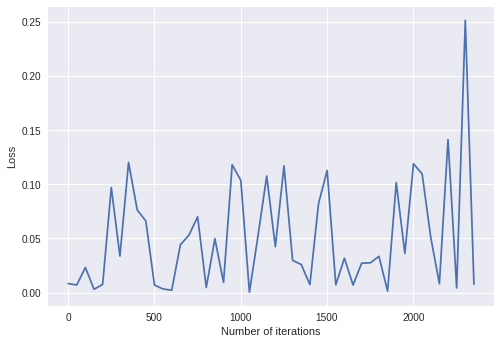

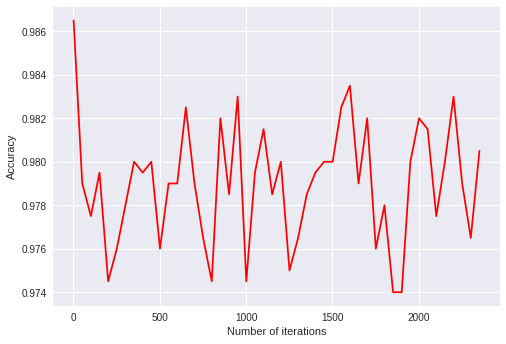

In [17]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iterations")
plt.ylabel("Loss")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy")
plt.show()

In [18]:
NUM_PREDICTIONS = 10
test_output, _ = cnn(test_x[:NUM_PREDICTIONS])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(pred_y, 'prediction number')
print(test_y[:NUM_PREDICTIONS].numpy(), 'real number')

[7 2 1 0 4 1 4 9 5 9] prediction number
[7 2 1 0 4 1 4 9 5 9] real number


## PLEASE FILL OUT THIS FORM
https://goo.gl/forms/5tKNEPAfdzBQWTNi2